In [1]:
import numpy as np
import struct
import os
from array import array
from os.path  import join

# MNIST Data Loader Class
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [2]:
import random
import matplotlib.pyplot as plt

# Set file paths based on added MNIST Datasets
input_path = join(os.getcwd(), 'datasets')
training_images_filepath = join(input_path, 'train-images-idx3-ubyte.gz')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte.gz')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte.gz')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte.gz')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

#show_images(images_2_show, titles_2_show)

x_train = np.array(x_train).reshape((len(x_train), -1))
y_train = np.array(y_train)
x_test = np.array(x_test).reshape((len(x_test), -1))
y_test = np.array(y_test)
print("Training Set Data  Shape: ", x_train.shape)
print("Training Set Label Shape: ", y_train.shape)
print("Test Set Data  Shape: ", x_test.shape)
print("Test Set Label Shape: ", y_test.shape)

Training Set Data  Shape:  (60000, 784)
Training Set Label Shape:  (60000,)
Test Set Data  Shape:  (10000, 784)
Test Set Label Shape:  (10000,)


In [3]:
def run_knn(x_train, y_train, x_test, y_test, k):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import metrics
    
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train, y_train)

    y_test_pred = knn_model.predict(x_test)
    test_acc = metrics.accuracy_score(y_test, y_test_pred)

    #print("KNN Test Accuracy: ", test_acc*100, "%")
    return test_acc

In [4]:
def get_random_idx(sample_size, data_size):
    rand_idx = np.array(sample_size, dtype=int)
    rand_idx = np.int_(np.round(np.random.rand(sample_size) * (data_size-1)))
    return rand_idx

def plot_accuracies(sample_size, random_accuracy):
    import matplotlib.pyplot as plt
    
    y = np.sum(random_accuracy, axis=1)/random_accuracy.shape[1]
    yerr = np.std(random_accuracy, axis=1)

    #print(sample_size.shape)
    #print(y.shape)
    #print(yerr.shape)
    
    plt.figure()
    plt.errorbar(sample_size, y, yerr)

In [5]:
def condense(x_train, y_train, x_test, y_test):
    #subset_idxs = np.array()
    #remaining_idxs = np.arange(0, x_train.shape[0], 1, dtype=int)
    subset_idxs = []

    for i in range(10): #mnist label classes
        for j in range(100):
            if(y_train[j] == i):
                subset_idxs.append(j)
                found = 1
                break
        if(found == 0):
            print("Couldn't find a label in 100 attempts")

    subset_idxs = np.array(subset_idxs)
    for iter in range(1):
        for i in range(x_train.shape[0]):
            found = run_knn(np.take(x_train, subset_idxs, axis=0), np.take(y_train, subset_idxs, axis=0), np.reshape(x_train[i], (1,-1)), np.reshape(y_train[i], (1,-1)), 1)
            if(found < 0.5):
                subset_idxs = np.append(subset_idxs, i)
            
        print("[Iter ", iter, "] Subset size: ", subset_idxs.shape[0], " Training accuracy: ", run_knn(np.take(x_train, subset_idxs, axis=0), np.take(y_train, subset_idxs, axis=0), x_train, y_train, 1), " Test Accuracy: ", run_knn(np.take(x_train, subset_idxs, axis=0), np.take(y_train, subset_idxs, axis=0), x_test, y_test, 1))


#condense(x_train, y_train, x_test, y_test)

In [6]:
M = [1000, 5000, 10000]
n_iterations = 5
random_prototyping_accuracy = np.zeros((len(M), n_iterations))

for i, m in enumerate(M):
    for iter in range(n_iterations):
        rand_idx = get_random_idx(m, x_train.shape[0])
        rand_data = np.take(x_train, rand_idx, axis=0)
        rand_labels = np.take(y_train, rand_idx, axis=0)
    
        random_prototyping_accuracy[i][iter] = run_knn(rand_data, rand_labels, x_test, y_test, 1)



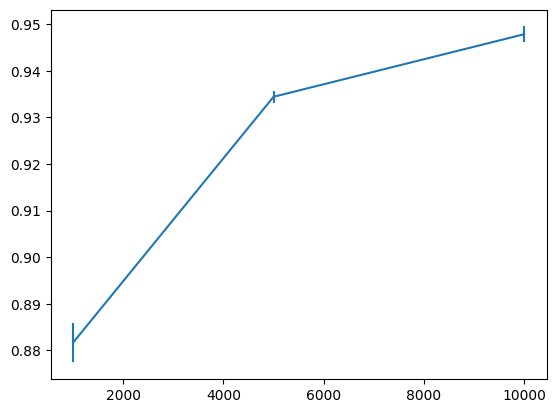

In [7]:
plot_accuracies(np.array(M), random_prototyping_accuracy)